In [1]:
pip install xgboost lightgbm catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 4.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 522.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 1.3 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from lightgbm import LGBMClassifier, LGBMRegressor 
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/PS-S3/Ep9/train.csv'
file_key_2 = 'Tabular-Playground-Series/PS-S3/Ep9/test.csv'
file_key_3 = 'Tabular-Playground-Series/PS-S3/Ep9/sample_submission.csv'
file_key_4 = 'Tabular-Playground-Series/PS-S3/Ep9/ConcreteStrengthData.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

bucket_object_4 = bucket.Object(file_key_4)
file_object_4 = bucket_object_4.get()
file_content_stream_4 = file_object_4.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
train = train.drop(columns = 'id', axis = 1)
train['is_generated'] = 1

test = pd.read_csv(file_content_stream_2)
test['is_generated'] = 1

original = pd.read_csv(file_content_stream_4)
original['is_generated'] = 0
original.columns = train.columns.tolist()

submission = pd.read_csv(file_content_stream_3)

train = pd.concat([train, original], axis = 0)

# Models

In [11]:
X = train.drop(columns = ['Strength'], axis = 1)
Y = train['Strength']

X['clippedAge'] = X.AgeInDays.clip(None, 40)
X['hasBlastFurnaceSlag'] = X.BlastFurnaceSlag != 0
X['hasFlyAshComponent'] = X.FlyAshComponent != 0
X['hasSuperplasticizerComponent'] = X.SuperplasticizerComponent != 0

def score_model(model, features_used, label=None):
    """Cross-validate a model with feature selection"""
    score_list = []
    oof = np.zeros_like(train[target])
    kf = KFold()
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        X_tr = train.iloc[idx_tr][features_used]
        X_va = train.iloc[idx_va][features_used]
        y_tr = train.iloc[idx_tr][target]
        y_va = train.iloc[idx_va][target]
        
#         X_tr = pd.concat([X_tr, original[features_used]], axis=0)
#         y_tr = pd.concat([y_tr, original[target]], axis=0)
        
        model.fit(X_tr, y_tr)
        trmse = mean_squared_error(y_tr, model.predict(X_tr), squared=False)
        y_va_pred = model.predict(X_va)
        rmse = mean_squared_error(y_va, y_va_pred, squared=False)
        if type(model) == Pipeline and type(model.steps[-1][1]) == GaussianProcessRegressor:
            print('Kernel:', model.steps[-1][1].kernel_)
        print(f"Fold {fold}: trmse = {trmse:.3f}   rmse = {rmse:.3f}")
        oof[idx_va] = y_va_pred
        score_list.append(rmse)

    rmse = sum(score_list) / len(score_list)
    print(f"Average rmse: {rmse:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, rmse, oof))

score_model(model = make_pipeline(StandardScaler(), Ridge(70)), features_used = X.columns)

NameError: name 'target' is not defined

In [11]:
X = train.drop(columns = ['Strength'], axis = 1)
Y = train['Strength']
X['WaterComponent_to_Cement_ratio'] = X['WaterComponent'] / (X['CementComponent'] + 1e-6)
X['Age_Water'] = X['AgeInDays'] / X['WaterComponent']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['WaterComponent_to_Cement_ratio'] = test_baseline['WaterComponent'] / (test_baseline['CementComponent'] + 1e-6)
test_baseline['Age_Water'] = test_baseline['AgeInDays'] / test_baseline['WaterComponent']

RF_md = RandomForestRegressor(n_estimators = 400,
                              max_depth = 4,
                              min_samples_split = 2,
                              min_samples_leaf = 2).fit(X, Y)
RF_pred = RF_md.predict(test_baseline)
submission['Strength'] = RF_pred
submission.head(10)

,id,Strength
0,5407,46.334474
1,5408,19.244896
2,5409,34.245083
3,5410,46.333850
4,5411,33.994653
5,5412,37.038962
6,5413,34.777062
7,5414,20.468258
8,5415,49.579359
9,5416,41.064615


In [37]:
X = train.drop(columns = ['Strength'], axis = 1)
Y = train['Strength']
X['WaterComponent_to_Cement_ratio'] = X['WaterComponent'] / (X['CementComponent'] + 1e-6)
# X['Age_Water'] = X['AgeInDays'] / X['WaterComponent'] 

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['WaterComponent_to_Cement_ratio'] = test_baseline['WaterComponent'] / (test_baseline['CementComponent'] + 1e-6)
# test_baseline['Age_Water'] = test_baseline['AgeInDays'] / test_baseline['WaterComponent']

GBR_md = GradientBoostingRegressor(n_estimators = 500,
                                   learning_rate = 0.01,
                                   max_depth = 2,
                                   min_samples_split = 2,
                                   min_samples_leaf = 2).fit(X, Y)
GBR_pred = GBR_md.predict(test_baseline)
submission['Strength'] = GBR_pred
submission.head(10)

,id,Strength
0,5407,46.655199
1,5408,20.734286
2,5409,33.784127
3,5410,44.606526
4,5411,30.298132
5,5412,39.234069
6,5413,32.900146
7,5414,23.303146
8,5415,45.657342
9,5416,40.385776


In [38]:
X = train.drop(columns = ['Strength'], axis = 1)
Y = train['Strength']
X['WaterComponent_to_Cement_ratio'] = X['WaterComponent'] / (X['CementComponent'] + 1e-6)
# X['Age_Water'] = X['AgeInDays'] / X['WaterComponent'] 

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['WaterComponent_to_Cement_ratio'] = test_baseline['WaterComponent'] / (test_baseline['CementComponent'] + 1e-6)
# test_baseline['Age_Water'] = test_baseline['AgeInDays'] / test_baseline['WaterComponent']

hist_md = HistGradientBoostingRegressor(l2_regularization = 0.01,
                                        early_stopping = False,
                                        learning_rate = 0.01,
                                        max_iter = 500,
                                        max_depth = 2,
                                        max_bins = 255,
                                        min_samples_leaf = 10,
                                        max_leaf_nodes = 10).fit(X, Y)

hist_pred = hist_md.predict(test_baseline)
submission['Strength'] = hist_pred
submission.head(10)

,id,Strength
0,5407,46.583556
1,5408,20.764205
2,5409,33.774408
3,5410,44.636735
4,5411,30.174076
5,5412,39.553087
6,5413,33.053790
7,5414,23.860628
8,5415,45.516656
9,5416,40.339184


In [90]:
X = train.drop(columns = ['Strength'], axis = 1)
Y = train['Strength']
X['WaterComponent_to_Cement_ratio'] = X['WaterComponent'] / (X['CementComponent'] + 1e-6)
# X['Age_Water'] = X['AgeInDays'] / X['WaterComponent']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['WaterComponent_to_Cement_ratio'] = test_baseline['WaterComponent'] / (test_baseline['CementComponent'] + 1e-6)
# test_baseline['Age_Water'] = test_baseline['AgeInDays'] / test_baseline['WaterComponent']

lgb_md = LGBMRegressor(n_estimators = 450,
                       max_depth = 3,
                       learning_rate = 0.01,
                       num_leaves = 20,
                       lambda_l1 = 3,
                       lambda_l2 = 3,
                       bagging_fraction = 0.5,
                       feature_fraction = 0.5).fit(X, Y)

lgb_pred = lgb_md.predict(test_baseline)
submission['Strength'] = lgb_pred
submission.head(10)

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


,id,Strength
0,5407,46.705488
1,5408,20.630575
2,5409,33.502170
3,5410,45.374059
4,5411,30.047531
5,5412,40.029964
6,5413,32.467993
7,5414,23.387835
8,5415,45.831396
9,5416,39.654332


In [39]:
X = train.drop(columns = ['Strength'], axis = 1)
Y = train['Strength']
X['WaterComponent_to_Cement_ratio'] = X['WaterComponent'] / (X['CementComponent'] + 1e-6)
# X['Age_Water'] = X['AgeInDays'] / X['WaterComponent']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['WaterComponent_to_Cement_ratio'] = test_baseline['WaterComponent'] / (test_baseline['CementComponent'] + 1e-6)
# test_baseline['Age_Water'] = test_baseline['AgeInDays'] / test_baseline['WaterComponent']

XGB_md = XGBRegressor(tree_method = 'hist',
                      colsample_bytree = 0.7, 
                      gamma = 0.8, 
                      learning_rate = 0.01, 
                      max_depth = 2, 
                      min_child_weight = 10, 
                      n_estimators = 1000, 
                      subsample = 0.5).fit(X, Y)

xgb_pred = XGB_md.predict(test_baseline)
submission['Strength'] = xgb_pred
submission.head(10)

,id,Strength
0,5407,47.142021
1,5408,19.864595
2,5409,32.336857
3,5410,45.707821
4,5411,28.157061
5,5412,40.651001
6,5413,32.121384
7,5414,23.301384
8,5415,47.360481
9,5416,38.579678


In [40]:
X = train.drop(columns = ['Strength'], axis = 1)
Y = train['Strength']
X['WaterComponent_to_Cement_ratio'] = X['WaterComponent'] / (X['CementComponent'] + 1e-6)
# X['Age_Water'] = X['AgeInDays'] / X['WaterComponent']

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['WaterComponent_to_Cement_ratio'] = test_baseline['WaterComponent'] / (test_baseline['CementComponent'] + 1e-6)
# test_baseline['Age_Water'] = test_baseline['AgeInDays'] / test_baseline['WaterComponent']

cat_md = CatBoostRegressor(loss_function = 'RMSE',
                           iterations = 1000,
                           learning_rate = 0.01,
                           depth = 3,
                           random_strength = 0.5,
                           bagging_temperature = 0.7,
                           border_count = 30,
                           l2_leaf_reg = 7,
                           verbose = False).fit(X, Y)

cat_pred = cat_md.predict(test_baseline)
submission['Strength'] = cat_pred
submission.head(10)

,id,Strength
0,5407,46.878175
1,5408,19.772559
2,5409,32.567903
3,5410,46.580035
4,5411,31.837363
5,5412,39.750692
6,5413,32.081954
7,5414,23.035144
8,5415,45.913035
9,5416,39.561986


In [41]:
submission['Strength'] = (cat_pred + xgb_pred + hist_pred + GBR_pred) / 4
submission.head()

,id,Strength
0,5407,46.814738
1,5408,20.283911
2,5409,33.115824
3,5410,45.382779
4,5411,30.116658


In [42]:
submission.to_csv('catboost_xgb_hist_GBR_full_original_submission_4.csv', index = False)

# Best Models Optimization

In [15]:
X = train.drop(columns = ['Strength'], axis = 1)
Y = train['Strength']
X['WaterComponent_to_Cement_ratio'] = X['WaterComponent'] / (X['CementComponent'] + 1e-6)

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['WaterComponent_to_Cement_ratio'] = test_baseline['WaterComponent'] / (test_baseline['CementComponent'] + 1e-6)

GBR_md = GradientBoostingRegressor(n_estimators = 1000,
                                   learning_rate = 0.01,
                                   max_depth = 2,
                                   min_samples_split = 2,
                                   min_samples_leaf = 2).fit(X, Y)
GBR_pred_train = GBR_md.predict(X)
GBR_pred = GBR_md.predict(test_baseline)


hist_md = HistGradientBoostingRegressor(l2_regularization = 0.01,
                                        early_stopping = False,
                                        learning_rate = 0.01,
                                        max_iter = 1000,
                                        max_depth = 2,
                                        max_bins = 255,
                                        min_samples_leaf = 10,
                                        max_leaf_nodes = 10).fit(X, Y)
hist_pred_train = hist_md.predict(X)
hist_pred = hist_md.predict(test_baseline)


XGB_md = XGBRegressor(tree_method = 'hist',
                      colsample_bytree = 0.7, 
                      gamma = 0.8, 
                      learning_rate = 0.01, 
                      max_depth = 2, 
                      min_child_weight = 10, 
                      n_estimators = 1000, 
                      subsample = 0.7).fit(X, Y)
xgb_pred_train = XGB_md.predict(X)
xgb_pred = XGB_md.predict(test_baseline)


cat_md = CatBoostRegressor(loss_function = 'RMSE',
                           iterations = 1000,
                           learning_rate = 0.01,
                           depth = 3,
                           random_strength = 0.5,
                           bagging_temperature = 0.7,
                           border_count = 30,
                           l2_leaf_reg = 5,
                           verbose = False).fit(X, Y)
cat_pred_train = cat_md.predict(X)
cat_pred = cat_md.predict(test_baseline)

In [24]:
class OptimizedEnsemble(object):
    
    def __init__(self):
        self.coef_ = 0

    def _rmse_loss(self, coef, X, y):
        
        ens = coef[0]*X[:, 0] + coef[1]*X[:, 1] + coef[2]*X[:, 2] + coef[3]*X[:, 3]
        ll = mean_squared_error(y, ens, squared = False)
        return ll

    def fit(self, X, y):
        loss_partial = partial(self._rmse_loss, X = X, y = y)
        initial_coef = [1/4, 1/4, 1/4, 1/4]
        cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = [(0, 1,) for i in range(len(initial_coef))]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'SLSQP', bounds = bounds, constraints = cons)

    def predict(self, X, coef):
        
        ens = coef[0]*X[:, 0] + coef[1]*X[:, 1] + coef[2]*X[:, 2] + coef[3]*X[:, 3]
        return ens

    def coefficients(self):
        return self.coef_['x']

In [25]:
models_pred_train = np.transpose((GBR_pred_train, hist_pred_train, xgb_pred_train, cat_pred_train))
models_pred_test = np.transpose((GBR_pred, hist_pred, xgb_pred, cat_pred))

opt_ens = OptimizedEnsemble()
opt_ens.fit(models_pred_train, Y)
coef = opt_ens.coefficients()
print(coef)
print(sum(coef))

ens_pred = opt_ens.predict(models_pred_test, coef)
submission['Strength'] = ens_pred
submission.head()

[5.89805982e-17 0.00000000e+00 1.43114687e-17 1.00000000e+00]
1.0


,id,Strength
0,5407,46.878972
1,5408,19.732393
2,5409,32.571737
3,5410,46.562442
4,5411,31.740334


In [26]:
submission.to_csv('catboost_xgb_hist_GBR_full_original_submission_opt_1.csv', index = False)

# Meta Learner

In [27]:
X = train.drop(columns = ['Strength'], axis = 1)
Y = train['Strength']
X['WaterComponent_to_Cement_ratio'] = X['WaterComponent'] / (X['CementComponent'] + 1e-6)

test_baseline = test.drop(columns = ['id'], axis = 1)
test_baseline['WaterComponent_to_Cement_ratio'] = test_baseline['WaterComponent'] / (test_baseline['CementComponent'] + 1e-6)

GBR_md = GradientBoostingRegressor(n_estimators = 1000,
                                   learning_rate = 0.01,
                                   max_depth = 2,
                                   min_samples_split = 2,
                                   min_samples_leaf = 2).fit(X, Y)
GBR_pred_train = GBR_md.predict(X)
GBR_pred = GBR_md.predict(test_baseline)


hist_md = HistGradientBoostingRegressor(l2_regularization = 0.01,
                                        early_stopping = False,
                                        learning_rate = 0.01,
                                        max_iter = 1000,
                                        max_depth = 2,
                                        max_bins = 255,
                                        min_samples_leaf = 10,
                                        max_leaf_nodes = 10).fit(X, Y)
hist_pred_train = hist_md.predict(X)
hist_pred = hist_md.predict(test_baseline)


XGB_md = XGBRegressor(tree_method = 'hist',
                      colsample_bytree = 0.7, 
                      gamma = 0.8, 
                      learning_rate = 0.01, 
                      max_depth = 2, 
                      min_child_weight = 10, 
                      n_estimators = 1000, 
                      subsample = 0.7).fit(X, Y)
xgb_pred_train = XGB_md.predict(X)
xgb_pred = XGB_md.predict(test_baseline)


cat_md = CatBoostRegressor(loss_function = 'RMSE',
                           iterations = 1000,
                           learning_rate = 0.01,
                           depth = 3,
                           random_strength = 0.5,
                           bagging_temperature = 0.7,
                           border_count = 30,
                           l2_leaf_reg = 5,
                           verbose = False).fit(X, Y)
cat_pred_train = cat_md.predict(X)
cat_pred = cat_md.predict(test_baseline)

In [56]:
train_md = pd.DataFrame({'GBC': GBR_pred_train, 'Hist': hist_pred_train, 
                         'XGB': xgb_pred_train, 'Cat': cat_pred_train,
                         'target': Y})

X = train_md.drop(columns = 'target', axis = 1)
Y = train_md['target']

test = pd.DataFrame({'GBC': GBR_pred, 'Hist': hist_pred, 
                     'XGB': xgb_pred, 'Cat': cat_pred})

In [34]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 18.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 11.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 67.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 42.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/78

In [85]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, input_dim = 4, kernel_initializer = 'normal', activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(16, activation = 'relu'),
        tf.keras.layers.Dense(8, activation = 'relu'),
        tf.keras.layers.Dense(1, activation = 'linear')
])

model.compile(optimizer = 'sgd', loss = tf.keras.losses.MeanSquaredError(), metrics = tf.keras.metrics.RootMeanSquaredError())

# model.compile(optimizer = 'Adam', loss = rmse, metrics = [rmse])

## Splitting data into training a testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Fitting model 
history = model.fit(X_train, Y_train, epochs = 100, batch_size = 32, validation_data = (X_test, Y_test))

Epoch 1/100
161/161 [==============================] - 1s 4ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/100
161/161 [==============================] - 0s 3ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/100
161/161 [==============================] - 0s 3ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/100
161/161 [==============================] - 0s 3ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/100
161/161 [==============================] - 0s 3ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 6/100
161/161 [==============================] - 1s 4ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 7/100
161/161 [=============

KeyboardInterrupt: 

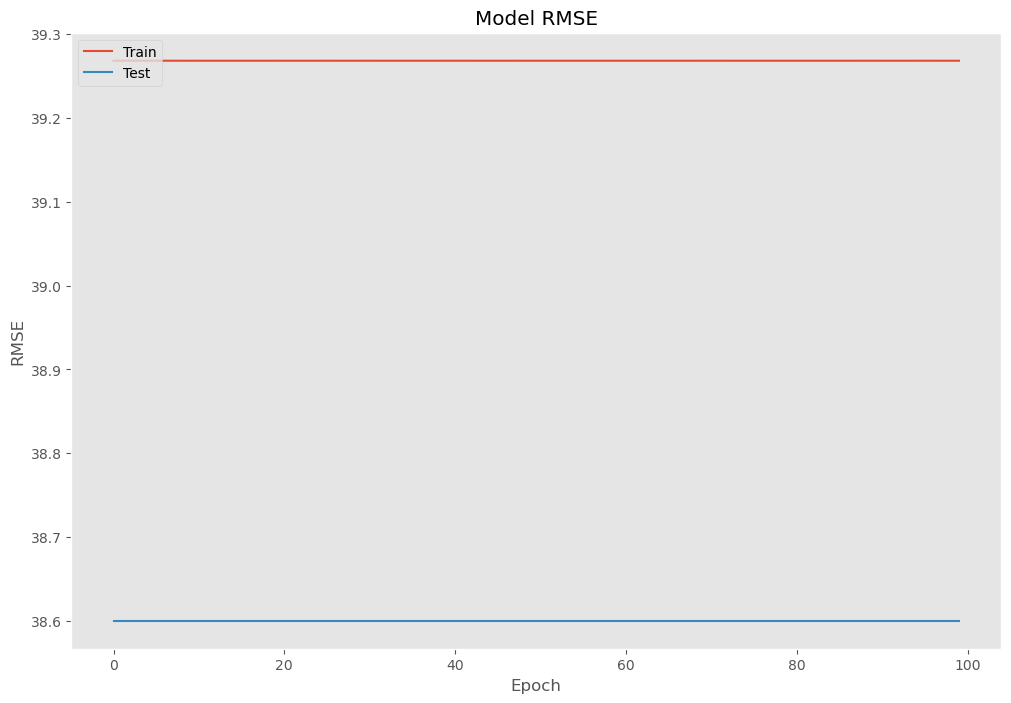

In [53]:
fig = plt.figure(figsize = (12, 8))

## Visualization of accuracy in train and test datasets
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.grid()
plt.show()

In [78]:
test = scaler.fit_transform(test)
test

array([[0.69776556, 0.68977353, 0.68162957, 0.69380973],
       [0.20780312, 0.19051303, 0.20359315, 0.15604491],
       [0.43101881, 0.42068856, 0.42251273, 0.4103881 ],
       ...,
       [0.56248723, 0.55605411, 0.54724454, 0.55345357],
       [0.49230781, 0.48150552, 0.48613092, 0.40164503],
       [0.25263401, 0.24366974, 0.24654032, 0.20818373]])

In [82]:
a = model.predict(test)

113/113 [==============================] - 0s 2ms/step


In [83]:
a

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)